### Imports 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import copy
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
iter_count = []

# Setting epsilon values for the ringnorm and ionosphere dataset based on experimentation (elaborated below)

eps_ringnorm = 1/10**5
eps_ionosphere = 1/10**2

NOTE : The epsilon values were set by running the EM repeatedly on varying inputs, we observed the values until the point at which the delta between each iteration becomes very minute, otherwise the program would run unnecessarily with results that are not that much superior. 

# Q1 ) EM Algorithm Implementation

The below code is an implementation of the Expectation Maximization based on the psuedocode provided in the assignment and the following reference : https://towardsdatascience.com/how-to-code-gaussian-mixture-models-from-scratch-in-python-9e7975df5252 

Expectation Maximization uses the principle of Gaussian mixture models(GMMs). Each cluster is modeled by a distinct gaussian having distinct means and varianaces. A GMM is used to model multiple gaussians together. 

We start with 2 random gaussians and iteratively keep adjusting the center and spread of the gaussians until each data point has the best possible probability of being in a given gauusian (cluster), the stopping condition for our iterations is based on the change in the means (centerpoints) after each iteration. If the delta/change in values between iterations is below a threshold (decided by us based on experimentation), the iterations stop. 

Answers to the prompts given in the assignment - 

1. Initializing each Gaussian

    * We initialize each Gaussian by choosing a random datapoint from our data set and using this as our mean _'mu'_. The prior probabilities are initally set as equal probability (1/k) where k is the numbe of clusters. Our covariance matrix is initialized as an identity matrix of dimensions _d x d_ where _'d'_ is the number of attributes in our datasets.   
    
    
2. Deciding ties

    * Ties are handled by assigning the datapoint to the 0th cluster (In other words the first cluster of the two given clusters). This is done in the _'map cluster'_ function. 
    
    
3. Stopping criteria

    * As explained above, the stopping condition is based on the _'epsilon'_ value, which is a threshold value. We calculate the Euclidean distance between the _'mu'_ vector values between iterations, if it is lesser than the threshold, we break out from the loops and cease the iterations. 



In [3]:
def expectation_maximization(df,k,e):
    '''
    x is a Pandas Dataframe without the labels
    k is the number of clusters we want to create from the given data 
    e is the epsilon value that will determine the stopping condition of the iterations
    '''
    x = df.iloc[:,:20]
    d = x.shape[1]
    n = x.shape[0]-1
    X = x.to_numpy()
    
    mean = []
    cov = []
    prior_prob = [] # weights
#     pdf = []
    prev_mean = []
    itr = 0

    for i in range(k):
    # initialization step for each cluster
        index = np.random.randint(0,n)
        mean.append(np.array(list(x.iloc[index])))
        cov.append(np.eye(d))
        prior_prob.append(1/k)
        
    while(True):
    
        pdf = []
        
        # E - Step
        
        for i in range(k):
            pdf.append(multivariate_normal.pdf(X, mean=mean[i], cov=cov[i], allow_singular=True))
        pdf = np.array(pdf)

        post_prob = []
        
        # M - Step
        
        for i in range(k):
            # Compute the posterior based on the previous prior and computed probabilites P(x|c)
            post_prob.append((pdf[i] * prior_prob[i]) / (np.sum([pdf[i] * prior_prob[i] for i in range(k)], axis=0)))
            
            # Update mean
            mean[i] = np.sum(post_prob[i].reshape(len(X),1) * X, axis=0) / (np.sum(post_prob[i]))
            
            # Update covariance matrix
            cov[i] = np.dot((post_prob[i].reshape(len(X),1) * (X - mean[i])).T, (X - mean[i])) / (np.sum(post_prob[i]))

            # Update prior probabilities
            prior_prob[i] = np.mean(post_prob[i])
            
            if itr == 0:
                prev_mean = copy.deepcopy(mean)
                itr+=1
                continue
        
        # Compute the delta between iterations and compare it to te threshold values (epsilon)
        delta=0
        for i in range(len(mean)):
            delta += np.square(np.sum(mean[i]-prev_mean[i]))

        if delta<e:

            return (mean,post_prob,itr)
        prev_mean = copy.deepcopy(mean)
        itr+=1

    return (mean,post_prob,itr)

### Helper functions to compute the cluster related metrics

In [4]:
def assign_cluster(df,post_prob):
    '''
    Function to assign the cluster numbers based on posterior probabilities
    '''
    res = []
    for i in range(len(post_prob[0])):
        max_index = -1
        max_val = post_prob[0][i]
        for j in range(len(post_prob)):
            if post_prob[j][i]>= max_val:
                max_index = j
                max_val = post_prob[j][i]
        res.append(max_index)
    df[df.shape[1]] = res

In [5]:
def map_cluster(df,mean):
    '''
    Function to map the predicted cluster number to either 1 or 0 when there are more than 2 clusters 
    '''
    map_to = {}
    data_0 = df.loc[df[20] == 0]
    data_1 = df.loc[df[20] == 1]
    df_mean_0 = np.array(data_0.iloc[:,:df.shape[1]-2].mean())
    df_mean_1 = np.array(data_1.iloc[:,:df.shape[1]-2].mean())
    
    for i in range(len(mean)):
        dist_0 = np.linalg.norm(mean[i] - df_mean_0)
#         print(dist_0)
        dist_1 = np.linalg.norm(mean[i] - df_mean_1)
#         print(dist_1)
#         print()
        if dist_0 <= dist_1:
            map_to[i] = 0
        else:
            map_to[i] = 1
            
    df[22] = df.apply(lambda row: map_to[row[21]],axis=1)
#     for i in range(1,max(df[21])):
#         temp_df = df[:,]
    

In [6]:
def cluster_accuracy(x):
    '''
    Function to check how accurate the generated clusters are
    '''
    try:
        x['match'] = np.where(x[20]==x[22],0,1)
    except:
        x['match'] = np.where(x[20]==x[21],0,1)
    return(100-(np.sum(x['match'])/x.shape[0])*100)

In [7]:
def cluster_error_rate(x):
    '''
    Obtain the error rate for the final 2 clusters 
    '''
    temp_df_0 = x.loc[x[20]==0]
    temp_df_1 = x.loc[x[20]==1]
    error_rate = np.sum(temp_df_0['match'])/temp_df_0.shape[0] + np.sum(temp_df_1['match'])/temp_df_1.shape[0] 
    return error_rate

# Q2 (a) EM on the Ringnorm Data 

Ringnorm dataset

In [8]:
ringnorm_data = pd.read_csv('Dataset.data', sep="\s+",header=None)
ringnorm_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.8494,2.1770,0.5982,1.6894,3.1137,-3.4060,3.7986,-2.6421,1.5779,-0.1808,...,1.6327,4.6640,1.0808,-1.1717,-1.6605,0.5775,1.6638,3.0895,-3.0276,0
1,0.9471,0.5431,0.7821,-0.4493,-0.0078,1.3164,0.7556,-0.0614,1.6040,1.6859,...,-0.3816,1.2591,0.6079,-2.2921,1.0078,2.6866,-1.4216,-0.6064,2.3738,1
2,0.7590,-0.3142,0.8975,-1.7429,2.0028,1.1171,0.9107,1.3603,-0.4886,-0.1444,...,1.1203,0.5985,0.4741,2.0260,1.4306,-0.3357,0.7900,1.1226,0.3024,1
3,0.5306,1.3742,0.5170,1.2261,1.1218,-0.0043,-1.2268,2.2773,1.0832,0.8879,...,1.0626,2.4544,0.5873,-0.7442,1.2155,0.9163,-0.4759,0.6004,-0.4768,1
4,-1.4430,1.0651,2.0710,2.0698,-0.8647,-0.7861,2.6554,-0.3656,0.9714,-0.3410,...,4.1953,-0.1172,-2.6937,0.0138,4.0970,1.3557,-0.9436,-0.6021,2.3482,0


In [9]:
iterations = []
mean = []
post_prob = []
error_rate = []
accuracy = []

### Apply the em algorithm on different values of k (20 times)

In [10]:
max_accuracy = -100
best_df = None
for k in range(2,5):  
    itr_k = []
    mean_k = []
    post_prob_k = []
    error_rate_k = []
    accuracy_k = []
    for i in range(20):
        data = ringnorm_data.copy(deep=True)
        mean,post,itr = expectation_maximization(data,k,eps_ringnorm)
        itr_k.append(itr)
        mean_k.append(mean)
        post_prob_k.append(post)
        assign_cluster(data,post)
        if k>2:
            map_cluster(data,mean)
        acc = cluster_accuracy(data)
        if acc > max_accuracy:
            best_df = data.copy(deep=True)
            max_accuracy=acc
        accuracy_k.append(acc)
        error_rate_k.append(cluster_error_rate(data))
    iterations.append(itr_k)
    mean.append(mean_k)
    post_prob.append(post_prob_k)
    error_rate.append(error_rate_k)
    accuracy.append(accuracy_k)

In [11]:
# Ref : https://stackoverflow.com/questions/23461713/obtaining-values-used-in-boxplot-using-python-and-matplotlib
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['No of Clusters'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_xdata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_xdata()[1]
        dict1['median'] = bp['medians'][i].get_xdata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_xdata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_xdata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

### Observations for Ringnorm Data

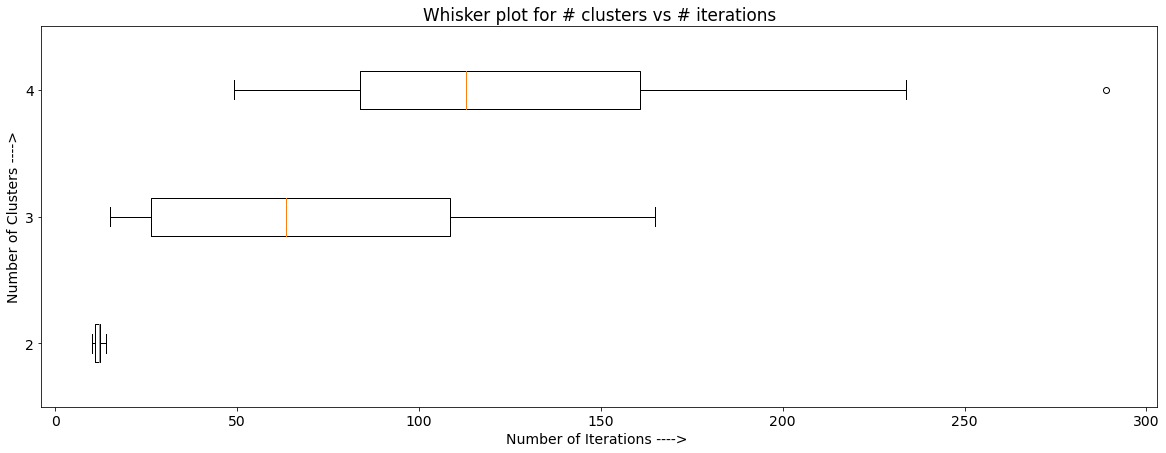

In [12]:
fig = plt.figure(figsize =(20,7))
ax = fig.add_subplot(111)

data = iterations
# Creating axes instance
bp = ax.boxplot(data,vert=0)

ax.set_yticklabels([i for i in range(2,5)])

plt.title("Whisker plot for # clusters vs # iterations")

plt.xlabel("Number of Iterations ----> ")
plt.ylabel("Number of Clusters ---->")

print()

In [13]:
labels = [i for i in range(2,5)]
print('A summary of the above plot')
get_box_plot_data(labels,bp)

A summary of the above plot


,No of Clusters,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,2,10.0,11.00,12.0,12.25,14.0
1,3,15.0,26.25,63.5,108.50,165.0
2,4,49.0,83.75,113.0,160.75,234.0


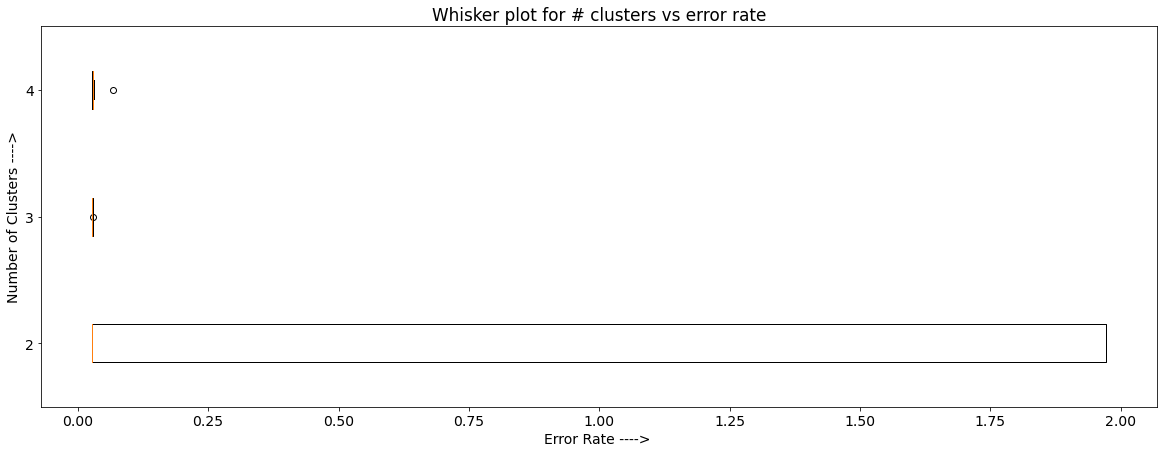

In [14]:
fig = plt.figure(figsize =(20,7))
ax = fig.add_subplot(111)

data = error_rate
# Creating axes instance
bp = ax.boxplot(data,vert = 0)

ax.set_yticklabels([i for i in range(2,5)])

plt.title("Whisker plot for # clusters vs error rate")

plt.xlabel("Error Rate ----> ")
plt.ylabel("Number of Clusters ---->")


print()

In [15]:
labels = [i for i in range(2,5)]
print('A summary of the above plot')
get_box_plot_data(labels,bp)

A summary of the above plot


,No of Clusters,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,2,0.027660,0.027660,0.027793,1.972340,1.972340
1,3,0.027130,0.027930,0.028085,0.028569,0.029329
2,4,0.026846,0.028145,0.028639,0.029305,0.030924


### The Dataframe with the best accuracy is as follows

##### NOTE : The last few columns are important to understand in order to understand the output dataframe below - 

* Column 20 : True output cluster ( given )
* Column 21 : Predicted cluster ( ranging from 1 - k  ) [ k is the number of clusters given by user ]
* Column 22 : Combined Predicted Cluster (cluster 0 or cluster 1)
* match ( The last column ): Has two possible conditions


    * '0' if the True output cluster ( column 20) == Combined Predicted cluster ( column 22 ).
    
    * '1' if the True output cluster ( column 20) != Combined Predicted cluster ( column 22 ).
    
       (While mapping 0 and 1 reversed may seem counterintuitive, it was done in order to calculate the error rates more conveniently )


In [16]:
best_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,match
0,0.8494,2.1770,0.5982,1.6894,3.1137,-3.4060,3.7986,-2.6421,1.5779,-0.1808,...,-1.1717,-1.6605,0.5775,1.6638,3.0895,-3.0276,0,0,0,0
1,0.9471,0.5431,0.7821,-0.4493,-0.0078,1.3164,0.7556,-0.0614,1.6040,1.6859,...,-2.2921,1.0078,2.6866,-1.4216,-0.6064,2.3738,1,2,1,0
2,0.7590,-0.3142,0.8975,-1.7429,2.0028,1.1171,0.9107,1.3603,-0.4886,-0.1444,...,2.0260,1.4306,-0.3357,0.7900,1.1226,0.3024,1,2,1,0
3,0.5306,1.3742,0.5170,1.2261,1.1218,-0.0043,-1.2268,2.2773,1.0832,0.8879,...,-0.7442,1.2155,0.9163,-0.4759,0.6004,-0.4768,1,2,1,0
4,-1.4430,1.0651,2.0710,2.0698,-0.8647,-0.7861,2.6554,-0.3656,0.9714,-0.3410,...,0.0138,4.0970,1.3557,-0.9436,-0.6021,2.3482,0,1,0,0
5,-0.2575,-4.6961,-0.5187,6.4689,-1.8778,-0.5566,-0.0622,5.5721,-0.0621,1.8130,...,-2.9411,-1.9527,-1.0073,-1.0416,1.8350,-1.1959,0,0,0,0
6,-0.6359,-2.2204,-3.0336,0.6882,1.3877,-0.5591,0.4120,1.1631,1.8872,4.4076,...,0.4121,0.1137,0.3136,1.5658,-0.5174,-0.9385,0,1,0,0
7,1.1435,0.3463,0.0766,1.1201,1.4600,1.3370,1.7402,0.2301,1.2990,-0.0058,...,1.9561,1.0903,-0.2421,1.6292,-0.0806,-0.5721,1,2,1,0
8,1.3202,-1.9843,-2.9616,1.3669,0.7493,0.5463,0.8489,-3.1955,3.6867,0.8201,...,-1.8675,-0.0516,-2.5092,1.3909,4.4480,3.7373,0,1,0,0
9,1.8390,3.0359,-0.0112,0.3940,0.1882,-0.5034,0.7615,-0.6824,2.1878,0.6929,...,1.5675,0.0755,0.6381,0.5105,0.0407,0.8369,1,2,1,0


### The overall accuracy of the above best predicted dataframe is

In [17]:
max_accuracy

98.66216216216216

The overall accuracy of the best predicted dataframe is

In [18]:
str(round(100-max_accuracy,3))+'%'

'1.338%'

# Q2 (b) EM on the Ionosphere Data 

Ionosphere dataset

In [19]:
ionosphere_data = pd.read_csv('ionosphere.data',header=None)
ionosphere_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


#### Replacing 'g' with 1 and 'b' with 0 

In [20]:
ionosphere_data[34] = np.where(ionosphere_data[34] == 'g', 1, ionosphere_data[34])
ionosphere_data[34] = np.where(ionosphere_data[34] == 'b', 0, ionosphere_data[34])

In [21]:
ionosphere_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [22]:
def expectation_maximization(df,k,e):
    '''
    x is a Pandas Dataframe without the labels
    k is the number of clusters we want to create from the given data 
    '''
    x = df.iloc[:,:34]
    d = x.shape[1]
    n = x.shape[0]-1
    X = x.to_numpy()
    
    mean = []
    cov = []
    prior_prob = [] # weights
#     pdf = []
    prev_mean = []
    itr = 0

    for i in range(k):
    # initialization step for each cluster
        index = np.random.randint(0,n)
        mean.append(np.array(list(x.iloc[index])))
        cov.append(np.eye(d))
        prior_prob.append(1/k)
        
    while(True):
    
        pdf = []
        for i in range(k):
            pdf.append(multivariate_normal.pdf(X, mean=mean[i], cov=cov[i], allow_singular=True))
        pdf = np.array(pdf)

        post_prob = []
        
        for i in range(k):

            post_prob.append((pdf[i] * prior_prob[i]) / (np.sum([pdf[i] * prior_prob[i] for i in range(k)], axis=0)))

            mean[i] = np.sum(post_prob[i].reshape(len(X),1) * X, axis=0) / (np.sum(post_prob[i]))
            cov[i] = np.dot((post_prob[i].reshape(len(X),1) * (X - mean[i])).T, (X - mean[i])) / (np.sum(post_prob[i]))

            prior_prob[i] = np.mean(post_prob[i])
            
            if itr == 0:

                prev_mean = copy.deepcopy(mean)
                itr+=1
                continue

        delta=0
        for i in range(len(mean)):
            delta += np.square(np.sum(mean[i]-prev_mean[i]))

        if delta<e:

            return (mean,post_prob,itr)
        prev_mean = copy.deepcopy(mean)
        itr+=1

    return (mean,post_prob,itr)

In [23]:
def map_cluster(df,mean):
    map_to = {}
    data_0 = df.loc[df[34] == 0]
    data_1 = df.loc[df[34] == 1]
    df_mean_0 = np.array(data_0.iloc[:,:df.shape[1]-2].mean())
    df_mean_1 = np.array(data_1.iloc[:,:df.shape[1]-2].mean())
    
    for i in range(len(mean)):
        dist_0 = np.linalg.norm(mean[i] - df_mean_0)

        dist_1 = np.linalg.norm(mean[i] - df_mean_1)

        if dist_0 <= dist_1:
            map_to[i] = 0
        else:
            map_to[i] = 1
            
    df[36] = df.apply(lambda row: map_to[row[35]],axis=1)
    

In [24]:
def cluster_accuracy(x):
    try:
        x['match'] = np.where(x[34]==x[36],0,1)
    except:
        x['match'] = np.where(x[34]==x[35],0,1)
    return(100-(np.sum(x['match'])/x.shape[0])*100)

In [25]:
def cluster_error_rate(x):
    temp_df_0 = x.loc[x[34]==0]
    temp_df_1 = x.loc[x[34]==1]
    error_rate = np.sum(temp_df_0['match'])/temp_df_0.shape[0] + np.sum(temp_df_1['match'])/temp_df_1.shape[0] 
    return error_rate

In [26]:
iterations = []
mean = []
post_prob = []
error_rate = []
accuracy = []

### Apply the em algorithm on different values of k (20 times)

In [27]:
max_accuracy = -100
best_df = None
for k in range(2,5):  
    itr_k = []
    mean_k = []
    post_prob_k = []
    error_rate_k = []
    accuracy_k = []
    for i in range(20):
        data = ionosphere_data.copy(deep=True)
        mean,post,itr = expectation_maximization(data,k,eps_ionosphere)
        itr_k.append(itr)
        mean_k.append(mean)
        post_prob_k.append(post)
        assign_cluster(data,post)
        if k>2:
            map_cluster(data,mean)
        acc = cluster_accuracy(data)
        if acc > max_accuracy:
            best_df = data.copy(deep=True)
            max_accuracy=acc
        accuracy_k.append(acc)
        error_rate_k.append(cluster_error_rate(data))
    iterations.append(itr_k)
    mean.append(mean_k)
    post_prob.append(post_prob_k)
    error_rate.append(error_rate_k)
    accuracy.append(accuracy_k)

In [28]:
# Ref : https://stackoverflow.com/questions/23461713/obtaining-values-used-in-boxplot-using-python-and-matplotlib
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['No of Clusters'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_xdata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_xdata()[1]
        dict1['median'] = bp['medians'][i].get_xdata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_xdata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_xdata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

### Observations for Ionosphere Data

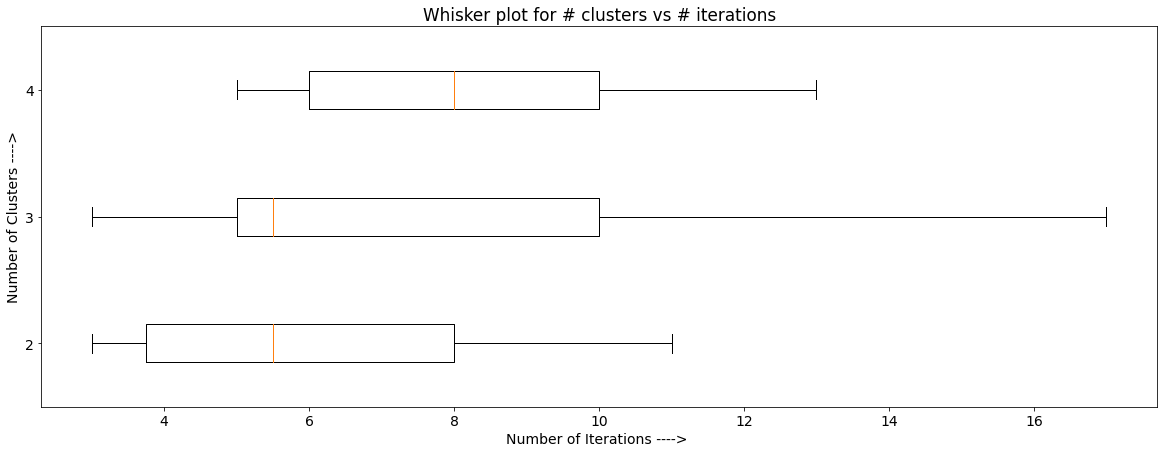

In [29]:
fig = plt.figure(figsize =(20,7))
ax = fig.add_subplot(111)

data = iterations
# Creating axes instance
bp = ax.boxplot(data,vert=0)

ax.set_yticklabels([i for i in range(2,5)])

plt.title("Whisker plot for # clusters vs # iterations")

plt.xlabel("Number of Iterations ----> ")
plt.ylabel("Number of Clusters ---->")


print()

In [30]:
labels = [i for i in range(2,5)]
print('A summary of the above plot')
get_box_plot_data(labels,bp)

A summary of the above plot


,No of Clusters,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,2,3.0,3.75,5.5,8.0,11.0
1,3,3.0,5.00,5.5,10.0,17.0
2,4,5.0,6.00,8.0,10.0,13.0


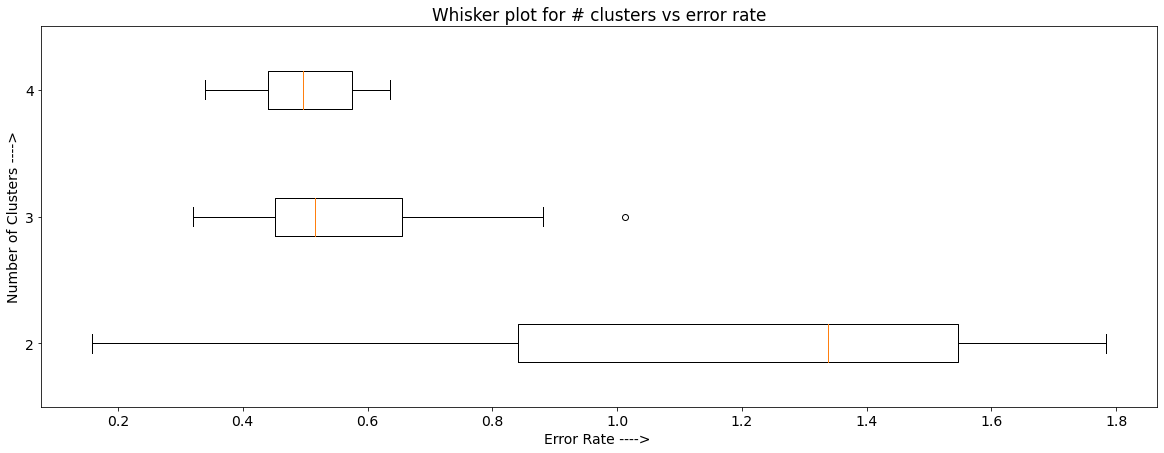

In [31]:
fig = plt.figure(figsize =(20,7))
ax = fig.add_subplot(111)

data = error_rate
# Creating axes instance
bp = ax.boxplot(data,vert = 0)

ax.set_yticklabels([i for i in range(2,5)])

plt.title("Whisker plot for # clusters vs error rate")

plt.xlabel("Error Rate ----> ")
plt.ylabel("Number of Clusters ---->")


print()

In [32]:
labels = [i for i in range(2,5)]
print('A summary of the above plot')
get_box_plot_data(labels,bp)

A summary of the above plot


,No of Clusters,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,2,0.158095,0.840635,1.338730,1.546429,1.784127
1,3,0.320317,0.452143,0.515079,0.654762,0.880635
2,4,0.340317,0.440952,0.496825,0.574524,0.635238


### The Dataframe with the best accuracy is as follows

##### NOTE : The last few columns are important to understand in order to understand the output dataframe below - 

* Column 33 : True output cluster ( given )
* Column 34 : Predicted cluster ( ranging from 1 - k  ) [ k is the number of clusters given by user ]
* Column 35 : Combined Predicted Cluster (cluster 0 or cluster 1)
* match ( The last column ): Has two possible conditions

    * '0' if the True output cluster ( column 20) == Combined Predicted cluster ( column 22 ).
    
    * '1' if the True output cluster ( column 20) != Combined Predicted cluster ( column 22 ).
    
       (While mapping 0 and 1 reversed may seem counterintuitive, it was done in order to calculate the error rates more conveniently )


In [33]:
best_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,match
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1,1,0
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0,0,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1,1,0
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0,0,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1,1,0
5,1,0,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,...,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011,0,1,1
6,1,0,0.97588,-0.10602,0.94601,-0.20800,0.92806,-0.28350,0.85996,-0.27342,...,-0.82510,0.04606,-0.82395,-0.04262,-0.81318,-0.13832,-0.80975,1,1,0
7,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,-1.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0,0,0
8,1,0,0.96355,-0.07198,1.00000,-0.14333,1.00000,-0.21313,1.00000,-0.36174,...,-0.69712,0.25435,-0.63919,0.45114,-0.72779,0.38895,-0.73420,1,1,0
9,1,0,-0.01864,-0.08459,0.00000,0.00000,0.00000,0.00000,0.11470,-0.26810,...,-0.02294,0.00000,0.00000,0.16595,0.24086,-0.08208,0.38065,0,0,0


### The overall accuracy of the above best predicted dataframe is

In [34]:
max_accuracy

93.44729344729345

### The overall error of the best predicted dataframe is

In [35]:
str(round(100-max_accuracy,3))+'%'

'6.553%'

## Final conclusions for the two given datasets based on the above observation (plots & dataframe)

Looking at the above observations, we can conclude that the EM algorithm performs a lot better on the ringorm data ( 98.7% accuracy ) as compared to the ionosphere data ( 92.8% accuracy ). However on an average, ringnorm takes a higher number of iterations to converge as opposed to the ionosphere data. 

One possible reason for the better performance of EM algorithm on the ringnorm data as opposed to the ionosphere data could be because the ringnorm data points could be more likely to be the drawn from a gaussian distribution and therefore EM performs better. This is because EM is based on the principle of fitting Data Points into varying Gaussians 

# Q3) Algorithm Design


## 3.1 )

For this problem, we'll be modifying the Knuth-Morris-Pratt (KMP) algorithm to find the longest prefix in P which is also a substring of D.  
- Normally, in KMP, we compute a fail table for the pattern in Ω(p) time. We'll keep this same here.  
- In the find_kmp method, we run over the string D until a match is found in P. We'll be modifying this part as follows:  
    - Initialise a variable, prefix as a null string
    - Whenever there is a match, we continue increasing both the pointers j & k normally.
    - Whenever there's a mismatch, we check the current value of k to see how much we've traversed in P.
    - If the length of the current prefix is less than P[: k], we update the prefix with this string. This is done in order to only keep the longest prefix.
    - The longest prefix is P[: k] which was matched in D implying that it is a substring in D as well.
    
Following is the code to do that:

In [36]:
# KMP failure function
def compute_kmp_fail(P):
    m = len(P)
    fail = [0] * m
    j = 1
    k = 0
    while j < m:
        if P[j] == P[k]:
            fail[j] = k + 1
            j += 1
            k += 1
        elif k > 0:
            k = fail[k - 1]
        else:
            j += 1
    return fail

# KMP
def find_kmp(T, P):
    prefix = ''
    n, m = len(T), len(P)
    if m == 0:
        return ''
    
    fail = compute_kmp_fail(P)  # Ω(p)
    j = 0
    k = 0
    while j < n:  # Ω(d)
        if T[j] == P[k]:
            if k == m - 1:
                # If we've traversed until the end of the string, the longest prefix is the whole pattern P itself.
                return P
            j += 1
            k += 1
        elif k > 0:
            # Check the current value of prefix
            # Only keep the longest one
            if prefix < P[: k]:
                prefix = P[: k]
            k = fail[k - 1]
        else:
            j += 1
    return prefix

As seen above, the whole program runs in **Ω(d + p)** time. We run the code on a few D & P pairs:

In [37]:
D = 'application'
P = 'apple'
result = find_kmp(D, P)
if result:
    print(f'The longest prefix in P which is also a substring in D is: "{result}"')
else:
    print('No such prefix.')

The longest prefix in P which is also a substring in D is: "appl"


In [38]:
D = 'applicationapples'
P = 'apple'
result = find_kmp(D, P)
if result:
    print(f'The longest prefix in P which is also a substring in D is: "{result}"')
else:
    print('No such prefix.')

The longest prefix in P which is also a substring in D is: "apple"


In [39]:
D = 'azzzzhhjjkkttyylolpple'
P = 'apple'
result = find_kmp(D, P)
if result:
    print(f'The longest prefix in P which is also a substring in D is: "{result}"')
else:
    print('No such prefix.')

The longest prefix in P which is also a substring in D is: "a"


In [40]:
D = 'zzzzhhjjkkttyylolpple'
P = 'apple'
result = find_kmp(D, P)
if result:
    print(f'The longest prefix in P which is also a substring in D is: "{result}"')
else:
    print('No such prefix.')

No such prefix.


## 3.2 )

### Solution:
Following is the proposed algorithm:
1. Let t = any random integer value
2. Sort array Z using merge sort. Time complexity: O(mlogm)
3. For every element in X and every element in Y, find (t - (x + y)) in Z using Binary Search.

**Psuedo-code:**
```
def check(X, Y, Z, t):
    for x in X:  # O(m)
        for y in Y:  # O(m)
            res = x + y
            if binary_search(Z, t - res):  # O(logm)
                return True
    return False
```

The total time-complexity:  
Merge-sort [O(mlogm)] + [O(m * m * logm)] = O(mlogm) + O(m^2logm) = **O(m^2 logm)**

## 3.3 )

### Solution:
Following is the proposed algorithm:
- Consider an already-built compressed trie of English-language words. In the worst case, the root and every other node except the leaf node has 26 pointers to their respective children.
- To delete a key K of length k, it needs to first exist in the trie.
- We search for the key K in O(k) time. In the worst case, a compressed trie is equivalent to it's corresponding normal trie.
- If the word is found, check it's endOfWord value. If it's true, this means it exists in the trie.
- Now check if it has any children. If yes, we can't delete the actual word, but can set it's endOfWord = False. e.g. K = 'book' and both 'book' and 'bookshop' exist in the compressed trie. Here, we can't actually delete 'book' but set it's endOfWord = False.
- If it doesn't have any children, delete that node and recursively delete it's parents until they have any other children. Stop when a node has another children. This will take O(k) time.
- If the parent node has just 1 other child, compress that child into it's parent.

**Total running time: O(k + k) = O(k)**